<a href="https://colab.research.google.com/github/hagijakobson/mptac-usage-example/blob/main/mptac_usage_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Disclaimer**: Plotly charts cannot be visualized in the .ipynb GitHub viewer. To view the charts, please download the notebook and run it locally or use a platform that supports interactive Plotly visualizations.

## Environment Setup

In [1]:
# The library needed to export Plotly figures as PDF and SVG
!pip install kaleido

  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl.metadata (15 kB)
Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl (79.9 MB)


##  Dependencies

In [94]:
# Data preprocessing
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Utility Functions

### Compression Algorithms

In [95]:
def replace_with_nan(row, flag_column='keepPoint'):
    """
    Replaces the values of columns with NaN if the specified flag is False.

    row: DataFrame row
    flag_column: name of the column containing the flag (default is 'keepPoint')
    """
    if not row[flag_column]:
        for col in row.index:
            if col != flag_column:
                row[col] = np.nan
    return row

#### Tiny Anomaly Compressor (TAC) algorithm

In [96]:
def TAC(dataset_original, windowLimit, m):
    # Output
    anomalysList = []
    keepPointList = []
    dataset_compressed = dataset_original.copy()

    # Local
    k = 1
    mu_k = np.zeros(dataset_original.shape[1])
    sigma2_k = 0
    anomalyCount = 0
    time = 1
    lastPoint = None

    for i , x_k in dataset_original.iterrows():
        x_k = x_k.to_numpy()
        if k == 1:
            mu_k = x_k
            sigma2_k = 0
            anomalysList.append(False)
            if time == 1:
                keepPointList.append(True)
            else:
                keepPointList.append(False)
        else:
            mu_k = (k-1)/k*mu_k + 1/k*x_k
            sigma2_k = (k-1)/k*sigma2_k + 1/(k-1)*(x_k - mu_k)**2

            if np.array_equal(x_k, lastPoint) and sigma2_k == 0:
                keepPointList.append(False)
                anomalysList.append(False)
            else:
                excentricidade_k = 1/k + ((mu_k - x_k)**2)/(k*sigma2_k)
                excentricidade_normalizada_k = excentricidade_k/2
                if excentricidade_normalizada_k > (m**2 + 1)/(2*k):
                    anomalysList.append(True)
                    anomalyCount += 1
                else:
                    anomalysList.append(False)

                if anomalyCount > windowLimit:
                    keepPointList.append(True)
                    # resetWindow()
                    k = 0
                    anomalyCount = 0
                else:
                    keepPointList.append(False)

        lastPoint = x_k
        k += 1
        time += 1

    dataset_compressed['isAnomaly'] = anomalysList
    dataset_compressed['keepPoint'] = keepPointList
    dataset_compressed = dataset_compressed.apply(replace_with_nan, axis=1)

    return dataset_compressed

#### Multivariate Parallel Tiny Anomaly Compressor (MPTAC) algorithm

In [97]:
def MPTAC(dataset_original, windowLimit, m):
    # Output
    anomalysList = []
    keepPointList = []
    dataset_compressed = dataset_original.copy()

    # Local
    k = 1
    mu_k = np.zeros(dataset_original.shape[1])
    sigma2_k = 0
    anomalyCount = 0
    time = 1
    lastPoint = None

    for i , x_k in dataset_original.iterrows():
        x_k = x_k.to_numpy()
        if k == 1:
            mu_k = x_k
            sigma2_k = 0
            anomalysList.append(False)
            if time == 1:
                keepPointList.append(True)
            else:
                keepPointList.append(False)
        else:
            mu_k = (k-1)/k*mu_k + 1/k*x_k
            sigma2_k = (k-1)/k*sigma2_k + 1/(k-1)*np.linalg.norm(x_k - mu_k)**2

            if np.array_equal(x_k, lastPoint) and sigma2_k == 0:
                keepPointList.append(False)
                anomalysList.append(False)
            else:
                excentricidade_k = 1/k + np.dot((mu_k - x_k),(mu_k - x_k))/(k*sigma2_k)
                excentricidade_normalizada_k = excentricidade_k/2
                if excentricidade_normalizada_k > (m**2 + 1)/(2*k):
                    anomalysList.append(True)
                    anomalyCount += 1
                else:
                    anomalysList.append(False)

                if anomalyCount > windowLimit:
                    keepPointList.append(True)
                    # resetWindow()
                    k = 0
                    anomalyCount = 0
                else:
                    keepPointList.append(False)

        lastPoint = x_k
        k += 1
        time += 1

    dataset_compressed['isAnomaly'] = anomalysList
    dataset_compressed['keepPoint'] = keepPointList
    dataset_compressed = dataset_compressed.apply(replace_with_nan, axis=1)

    return dataset_compressed

#### Multivariate Sequential Tiny Anomaly Compressor (MSTAC) algorithm

In [98]:
def MSTAC(dataset_original, windowLimit, m):
    datasetCompressedSequentialDict = {}

    for i, column in enumerate(dataset_original.columns):
        datasetCompressedSequentialDict[column] = TAC(pd.DataFrame(dataset_original[column]), windowLimitList[i], mList[i])

    dataset_compressed_sequential_df = pd.DataFrame()
    mask_df = pd.DataFrame()
    for variable in datasetCompressedSequentialDict:
        dataset_compressed_sequential_df = pd.concat([dataset_compressed_sequential_df,datasetCompressedSequentialDict[variable][variable]], axis=1)
        mask_df[variable] = datasetCompressedSequentialDict[variable]['keepPoint']

    return dataset_compressed_sequential_df, mask_df

### Model Optimizers

#### MPTAC/TAC Optimizer

**Disclaimer**: For optimizer TAC model pass the univariate time series as a 1-column pandas dataframe

In [99]:
def MPTAC_TAC_Optimizer(dataset_original, window_size, m, log=True):
    # window_size = np.arange(2, 30, 2)
    # m = np.round(np.arange(0.1, 2.1, 0.1), 2)

    # Create the grid of combinations
    grid1, grid2 = np.meshgrid(window_size, m)

    # Combine the grids into a single array of combinations
    combinations = np.column_stack([grid1.ravel(), grid2.ravel()])
    combinations_df = pd.DataFrame(combinations, columns=['windowLimit','m'])

    #
    numberOfOriginalSamples = dataset_original.shape[0]
    colunas = list(dataset_original.columns) + ['total']
    df_aux = pd.DataFrame(np.zeros([len(combinations),len(colunas)]), columns=colunas)
    cfScoreList = []
    compresionRateList = []
    compressionFactorList = []

    i = 0
    for windowLimit, m in combinations:
        if(i%10==0 and log):
            print(i)
        df_compressed = MPTAC(dataset_original, windowLimit, m)
        dataset_decompressed = df_compressed.drop(columns=['isAnomaly','keepPoint']).interpolate(method='linear')

        normalizedCrossCorrelation = calculate_normalized_cross_correlation(dataset_original, dataset_decompressed)
        df_aux.iloc[i] =  pd.DataFrame(data=[normalizedCrossCorrelation])

        numberOfSavedSamples = sum(df_compressed['keepPoint'])
        compresionRate = 1 - numberOfSavedSamples/numberOfOriginalSamples
        compresionRateList.append(compresionRate)
        cfScoreList.append(CFScore(1,compresionRate, normalizedCrossCorrelation['Total']))
        compressionFactorList.append(numberOfOriginalSamples/numberOfSavedSamples)
        i += 1

    df_aux['compresionRatio'] = compresionRateList
    df_aux['compressionFactor'] = compressionFactorList
    df_aux['CFScore'] = cfScoreList

    return pd.concat([combinations_df,df_aux], axis=1).sort_values(by='CFScore',ascending=False)

### Metrics

#### Normalized Cross-Correlation (NCC)

In [100]:
def calculate_normalized_cross_correlation(df1, df2):
    """
    Calculates the normalized cross-correlation for each variable between two datasets.
    df1: first DataFrame
    df2: second DataFrame
    return: dictionary with the normalized cross-correlation for each variable and the average of the correlations
    """
    corr_dict = {}
    total_corr = 0
    num_vars = len(df1.columns)

    for column in df1.columns:
        # Normalizar as colunas
        norm_df1 = (df1[column] - np.mean(df1[column])) / np.std(df1[column])
        norm_df2 = (df2[column] - np.mean(df2[column])) / np.std(df2[column])

        # Calcular a NCC
        ncc = np.mean(norm_df1 * norm_df2)
        corr_dict[column] = ncc
        total_corr += ncc

    # Calcular a média das correlações individuais
    corr_dict['Total'] = total_corr / num_vars

    return corr_dict

In [101]:
# def calculate_normalized_cross_correlation(df1, df2):
#     """
#     Calcula a correlação cruzada normalizada para cada variável entre dois datasets.
#     df1: primeiro DataFrame
#     df2: segundo DataFrame
#     return: dicionário com correlação cruzada normalizada de cada variável e a média das correlações
#     """
#     corr_dict = {}
#     total_corr = 0
#     num_vars = len(df1.columns)

#     for column in df1.columns:
#         corr = np.corrcoef(df1[column], df2[column])[0, 1]
#         corr_dict[column] = corr
#         total_corr += corr

#     # Calcular a média das correlações individuais
#     corr_dict['Total'] = total_corr / num_vars

#     return corr_dict

#### Compression F<sub>β</sub> Coefficient (CF<sub>β</sub>)

In [102]:
def CFScore(beta, cr, ncc):
    return (1+beta**2)*(cr*ncc)/((beta**2)*cr + ncc)

#### Root Mean Squared Error (RMSE)

In [103]:
def calculate_rmse(df1, df2):
    """
    Calculates the RMSE for each variable and the total RMSE between two datasets.
    df1: first DataFrame
    df2: second DataFrame
    return: dictionary with the RMSE for each variable and the total RMSE
    """
    rmse_dict = {}
    for column in df1.columns:
        rmse = np.sqrt(mean_squared_error(df1[column], df2[column]))
        rmse_dict[column] = rmse

    # # Calcular o RMSE total considerando todos os valores combinados
    # total_rmse = np.sqrt(mean_squared_error(df1.values.flatten(), df2.values.flatten()))
    # rmse_dict['Total'] = total_rmse

    return rmse_dict

### Visualization

#### plot_dataframes_with_mask

In [104]:
def plot_dataframes_with_mask(df1, df2, mask, y_labels, x_range, margin_factor=0.1):
    """
    Plots columns from two DataFrames as continuous lines and applies a mask to the second DataFrame to plot points where the values are valid.

    Parameters:
    df1 (pd.DataFrame): First fully populated DataFrame.
    df2 (pd.DataFrame): Second fully populated DataFrame.
    mask (np.array): Boolean mask indicating the points to be highlighted in the second DataFrame.
    y_labels (list): List of labels for the y-axis of each subplot.
    x_range (tuple): Range (min, max) for the initial zoom on the x-axis.
    margin_factor (float): Margin factor to adjust the space around the y-axis values.
    """
    # Check if the DataFrames have the same columns
    if not df1.columns.equals(df2.columns):
        raise ValueError("The DataFrames must have the same columns")

    # Check if the mask has the same length as the DataFrame
    if len(mask) != len(df2):
        raise ValueError("The mask must have the same length as the DataFrame")

    # Check if the y_labels list has the same length as the number of columns
    if len(y_labels) != len(df1.columns):
        raise ValueError("The y_labels list must have the same length as the number of columns")

    # Create the chart
    fig = make_subplots(rows=len(df1.columns), cols=1, shared_xaxes=True, vertical_spacing=0.02)

    # Iterate over the columns and add the corresponding traces
    for i, column in enumerate(df1.columns):
        # Add the continuous line for the column from the first DataFrame
        fig.add_trace(go.Scatter(
            x=np.arange(len(df1)),
            y=df1[column],
            mode='lines',
            line=dict(color='blue'),
            showlegend=False
        ), row=i+1, col=1)

        # Add the continuous line for the column from the second DataFrame
        fig.add_trace(go.Scatter(
            x=np.arange(len(df2)),
            y=df2[column],
            mode='lines',
            line=dict(color='red'),
            showlegend=False
        ), row=i+1, col=1)

        # Add the points applied by the mask in the column from the second DataFrame
        fig.add_trace(go.Scatter(
            x=np.arange(len(df2))[mask],
            y=df2[column][mask],
            mode='markers',
            marker=dict(color='red', symbol='circle', size=8),
            showlegend=False
        ), row=i+1, col=1)

        # Update the y_range based on the provided x_range and apply the margin_factor
        x_min, x_max = x_range
        y_min = min(df1[column][x_min:x_max].min(), df2[column][x_min:x_max].min())
        y_max = max(df1[column][x_min:x_max].max(), df2[column][x_min:x_max].max())

        # Apply the margin factor
        y_margin = margin_factor * (y_max - y_min)
        fig.update_yaxes(title_text=y_labels[i], row=i+1, col=1, range=[y_min - y_margin, y_max + y_margin])

    # Add traces to the legend
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(color='blue'),
        name='Original'
    ))

    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(color='red'),
        name='Decompressed'
    ))

    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(color='red', symbol='circle', size=8),
        name='Sample saved'
    ))

    # Adjust layout with the initial zoom on x_range
    fig.update_layout(
        height=300 * len(df1.columns),  # Adjust the figure height
        title="Original vs Decompressed",
        margin=dict(l=20, r=20, t=40, b=40),  # Adjust the outer margins
        xaxis=dict(range=x_range),  # Set the initial zoom on the x-axis
        font=dict(size=18, family='Arial Black')
    )

    # Show the chart
    fig.show()

    # Adjustments to the figure before saving as PDF and SVG
    # Set the global font
    fig.update_layout(
        font=dict(
            family="Arial",  # Set the font family
            size=20,         # Set the font size
            color="black",   # Set the font color
        ),
        margin=dict(l=20, r=20, t=40, b=40),  # Adjust the outer margins
    )
    fig.write_image("results_execucao_paralela.pdf", format='pdf',width=1478,height=1500)
    fig.write_image("results_execucao_paralela.svg", format='svg',width=1478,height=1500)

#### plot_dataframes_with_mask_df

In [105]:
def plot_dataframes_with_mask_df_teste(df1, df2, mask_df, y_labels, x_range=None, margin_factor=0.1):
    """
    Plots columns from two DataFrames as continuous lines and applies a mask to the second DataFrame to plot points where the values are valid.

    Parameters:
    df1 (pd.DataFrame): First fully populated DataFrame.
    df2 (pd.DataFrame): Second fully populated DataFrame.
    mask_df (pd.DataFrame): DataFrame containing the boolean masks, where each column is a mask for the respective column of the DataFrames.
    y_labels (list): List of labels for the y-axis of each subplot.
    x_range (tuple): Range for the x-axis for the initial zoom (optional).
    margin_factor (float): Factor to adjust the y-axis limits based on minimum and maximum values (default 0.1, i.e., 10% margin).
    """
    if not df1.columns.equals(df2.columns):
        raise ValueError("The DataFrames df1 and df2 must have the same columns")

    if not mask_df.columns.equals(df2.columns):
        raise ValueError("The mask DataFrame must have the same columns as the DataFrames")

    if len(mask_df) != len(df2):
        raise ValueError("The mask DataFrame must have the same number of rows as the DataFrames")

    if len(y_labels) != len(df1.columns):
        raise ValueError("The y_labels list must have the same length as the number of columns")

    # Set x_range to default if not provided
    if x_range is None:
        x_range = (0, len(df1))

    fig = make_subplots(rows=len(df1.columns), cols=1, shared_xaxes=True, vertical_spacing=0.02)

    for i, column in enumerate(df1.columns):
        # Filter the data for the x_range interval
        x_start, x_end = x_range
        df1_filtered = df1[column].iloc[x_start:x_end]
        df2_filtered = df2[column].iloc[x_start:x_end]

        # Calculate the y-axis limits based on the filtered values
        y_min = min(df1_filtered.min(), df2_filtered.min())
        y_max = max(df1_filtered.max(), df2_filtered.max())

        # Adding a margin to the y_range
        # estava assim
        # y_range = (y_min - margin_factor * abs(y_min), y_max + margin_factor * abs(y_max))
        y_margin = margin_factor * (y_max - y_min)

        #########################################################################################
        # # Atualizar o y_range com base no x_range fornecido e aplicar o margin_factor
        # x_min, x_max = x_range
        # y_min = min(df1[column][x_min:x_max].min(), df2[column][x_min:x_max].min())
        # y_max = max(df1[column][x_min:x_max].max(), df2[column][x_min:x_max].max())

        # # Aplicar o fator de margem
        # y_margin = margin_factor * (y_max - y_min)
        # fig.update_yaxes(title_text=y_labels[i], row=i+1, col=1, range=[y_min - y_margin, y_max + y_margin])
        #########################################################################################

        # Add traces to the chart
        fig.add_trace(go.Scatter(
            x=np.arange(len(df1))[x_start:x_end],
            y=df1_filtered,
            mode='lines',
            line=dict(color='blue'),
            showlegend=False
        ), row=i+1, col=1)

        fig.add_trace(go.Scatter(
            x=np.arange(len(df2))[x_start:x_end],
            y=df2_filtered,
            mode='lines',
            line=dict(color='red'),
            showlegend=False
        ), row=i+1, col=1)

        fig.add_trace(go.Scatter(
            x=np.arange(len(df2))[x_start:x_end][mask_df[column].iloc[x_start:x_end]],
            y=df2_filtered[mask_df[column].iloc[x_start:x_end]],
            mode='markers',
            marker=dict(color='red', symbol='circle', size=8),
            showlegend=False
        ), row=i+1, col=1)

        fig.update_yaxes(title_text=y_labels[i], range=[y_min - y_margin, y_max + y_margin], row=i+1, col=1)
        ## estava assim antes
        #fig.update_yaxes(title_text=y_labels[i], range=y_range, row=i+1, col=1)
        #print(y_range)

    # Apply the x-axis range
    fig.update_xaxes(range=x_range, row=len(df1.columns), col=1)

    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(color='blue'),
        name='Original'
    ))

    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(color='red'),
        name='Decompressed'
    ))

    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(color='red', symbol='circle', size=8),
        name='Sample saved'
    ))

    fig.update_layout(
        height=300 * len(df1.columns),
        title="Original vs Decompressed",
        margin=dict(l=20, r=20, t=40, b=40),
        font=dict(size=18, family='Arial Black')
    )

    fig.update_xaxes(title_text='k', row=len(df1.columns), col=1)

    fig.show()

    # Adjustments to the figure before saving as PDF and SVG
    # Set the global font
    fig.update_layout(
        font=dict(
            family="Arial",  # Set the font family
            size=20,         # Set the font size
            color="black",   # Set the font color
        ),
        margin=dict(l=20, r=20, t=40, b=40),  # Adjust the outer margins
    )
    #fig.write_image("results_execucao_paralela.pdf", format='pdf',width=1478,height=1500)
    fig.write_image("results_execucao_sequencial.svg", format='svg',width=1478,height=1500)

#### plot_pdf_comparison

In [106]:
def plot_pdf_comparison_with_df(df1, df2, x_labels):
    """
    Plots the probability distribution function (PDF) for each variable in the two datasets.
    df1: first DataFrame
    df2: second DataFrame
    """
    num_vars = len(df1.columns)

    # Set up subplots
    fig = make_subplots(rows=num_vars, cols=1, shared_xaxes=False, vertical_spacing=0.05)

    for i, column in enumerate(df1.columns):
        # Calculate the KDE values for df1
        kde1 = sns.kdeplot(df1[column], label='Original', color='blue')
        x1, y1 = kde1.get_lines()[0].get_data()
        kde1.clear()

        # Calculate the KDE values for df2
        kde2 = sns.kdeplot(df2[column], label='Decompressed', color='red')
        x2, y2 = kde2.get_lines()[0].get_data()
        kde2.clear()

        # Add traces for df1
        fig.add_trace(go.Scatter(
            x=x1,
            y=y1,
            mode='lines',
            name='Original',
            line=dict(color='blue'),
            showlegend=(i == 0)  # Show legend only on the first subplot
        ), row=i+1, col=1)

        # Add traces for df2
        fig.add_trace(go.Scatter(
            x=x2,
            y=y2,
            mode='lines',
            name='Decompressed',
            line=dict(color='red'),
            showlegend=(i == 0)  # Show legend only on the first subplot
        ), row=i+1, col=1)

        # Update the axis titles for each subplot
        fig.update_yaxes(title_text='Density', row=i+1, col=1)
        fig.update_xaxes(title_text=x_labels[i], row=i+1, col=1)

    # # Adicionar traços fictícios para a legenda (sem duplicar)
    # fig.add_trace(go.Scatter(
    #     x=[None],
    #     y=[None],
    #     mode='lines',
    #     line=dict(color='blue'),
    #     name='Original',
    #     showlegend=False
    # ))

    # fig.add_trace(go.Scatter(
    #     x=[None],
    #     y=[None],
    #     mode='lines',
    #     line=dict(color='red'),
    #     name='Decompressed',
    #     showlegend=False
    # ))

    # Adjust layout
    fig.update_layout(
        height=300 * num_vars,  # Adjust the figure height
        margin=dict(l=20, r=20, t=40, b=40),  # Adjust the outer margins
        showlegend=True,
        font=dict(size=18, family='Arial Black')
    )

    # Show the chart
    fig.show()

    # Adjustments to the figure before saving as PDF and SVG
    # Set the global font
    fig.update_layout(
        font=dict(
            family="Arial",  # Set the font family
            size=20,         # Set the font size
            color="black",   # Set the font color
        ),
        margin=dict(l=20, r=20, t=40, b=40),  # Adjust the outer margins
    )
    #fig.write_image("results_execucao_paralela.pdf", format='pdf',width=1478,height=1500)
    fig.write_image("pdf_execucao_paralela.svg", format='svg',width=1478,height=1500)

##  Data Loading

In [107]:
dataset = pd.read_csv('/content/dados_freematics_teda_friday.csv')
dataset.head()

,id_device,email,time_sensor,time_session,timestamp_col,cpu_temp,battery_voltage,engine_load,coolant_temp,intake_map,...,accz,magnitude,area_radar,cloud_qtd,teda_time,autocloud_time,total_time,cloud_index,reset_window,other_info
0,UCFLVV1Y,thaisaraujom16@gmail.com,2024-06-14 16:36:27,2024-06-14 16:36:27,596504,47*DF,14.12,9,NaN,NaN,...,-0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""B3"": 0, ""B9"": 923.940002, ""BB"": 0.000153, ""B..."
1,UCFLVV1Y,thaisaraujom16@gmail.com,2024-06-14 16:36:28,2024-06-14 16:36:28,595502,47*58,14.06,8,NaN,NaN,...,-0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""B3"": 0, ""B9"": 875.804993, ""BB"": 0.000157, ""B..."
2,UCFLVV1Y,thaisaraujom16@gmail.com,2024-06-14 16:36:28,2024-06-14 16:36:28,618596,47*C7,12.95,13,NaN,NaN,...,-0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""B3"": 0, ""B9"": 1152.030029, ""BB"": 0.000153, ""..."
3,UCFLVV1Y,thaisaraujom16@gmail.com,2024-06-14 16:36:32,2024-06-14 16:36:32,619571,48*F1,12.73,14,NaN,NaN,...,-0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""B3"": 0, ""B9"": 1265.479980, ""BB"": 0.000250, ""..."
4,UCFLVV1Y,thaisaraujom16@gmail.com,2024-06-14 16:36:32,2024-06-14 16:36:32,622550,48*A1,12.82,18,NaN,NaN,...,-0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""B3"": 0, ""B9"": 1536.749878, ""BB"": 0.000149, ""..."


In [108]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10365 entries, 0 to 10364
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_device        10365 non-null  object 
 1   email            10365 non-null  object 
 2   time_sensor      10365 non-null  object 
 3   time_session     10365 non-null  object 
 4   timestamp_col    10365 non-null  int64  
 5   cpu_temp         10365 non-null  object 
 6   battery_voltage  10365 non-null  float64
 7   engine_load      10365 non-null  int64  
 8   coolant_temp     0 non-null      float64
 9   intake_map       0 non-null      float64
 10  rpm              10365 non-null  int64  
 11  speed            10365 non-null  int64  
 12  timing_advance   0 non-null      float64
 13  intake_temp      0 non-null      float64
 14  maf_flow         0 non-null      float64
 15  throttle         10365 non-null  int64  
 16  fuel_level       0 non-null      float64
 17  engine_oil_t

##  Data Preprocessing

### Feature selection

In [109]:
dataset.columns

Index(['id_device', 'email', 'time_sensor', 'time_session', 'timestamp_col',
       'cpu_temp', 'battery_voltage', 'engine_load', 'coolant_temp',
       'intake_map', 'rpm', 'speed', 'timing_advance', 'intake_temp',
       'maf_flow', 'throttle', 'fuel_level', 'engine_oil_temp', 'value12',
       'latitude', 'longitude', 'altitude', 'course', 'sattelites',
       'signal_level', 'accx', 'accy', 'accz', 'magnitude', 'area_radar',
       'cloud_qtd', 'teda_time', 'autocloud_time', 'total_time', 'cloud_index',
       'reset_window', 'other_info'],
      dtype='object')

In [110]:
features_selecteds = ['battery_voltage','engine_load','rpm','speed','throttle']
dataset_original = dataset[features_selecteds]
dataset_original

,battery_voltage,engine_load,rpm,speed,throttle
0,14.12,9,1386,49,18
1,14.06,8,1373,49,17
2,12.95,13,1491,53,20
3,12.73,14,1522,54,22
4,12.82,18,1598,57,25
...,...,...,...,...,...
10360,13.42,11,1615,15,18
10361,13.39,10,1648,17,18
10362,14.29,4,870,4,14
10363,13.46,4,884,2,14


## Exploratory Data Analysis (EDA)

In [111]:
dataset_original.describe()

,battery_voltage,engine_load,rpm,speed,throttle
count,10365.000000,10365.000000,10365.000000,10365.000000,10365.000000
mean,13.520485,11.067824,1608.331597,45.419875,18.863676
std,0.787704,8.377027,442.919476,25.966755,7.547204
min,10.640000,0.000000,0.000000,0.000000,11.000000
25%,12.820000,4.000000,1379.000000,25.000000,14.000000
50%,13.350000,9.000000,1617.000000,48.000000,18.000000
75%,14.080000,15.000000,1875.000000,66.000000,21.000000
max,15.390000,49.000000,3401.000000,102.000000,88.000000


### Visualization

In [112]:
dataset_original.shape

(10365, 5)

In [113]:
# Set up subplots
fig = make_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.05)

feature_legend = ['Battery Voltage', 'Engine Load', 'RPM', 'Speed', 'Throttle']

# Plot each feature in a subplot
for i, feature in enumerate(dataset_original.columns):
    fig.add_trace(go.Scatter(
        x=dataset_original.index+1,
        y=dataset_original[feature],
        mode='lines',
        name=feature_legend[i]
    ), row=i+1, col=1)
    fig.update_yaxes(title_text=feature_legend[i], row=i+1, col=1)
    fig.update_xaxes(showgrid=True, row=i+1, col=1)
    fig.update_yaxes(showgrid=True, row=i+1, col=1)

# Adjust layout
fig.update_layout(
    height=300 * len(feature_legend),  # Adjust the figure height
    #width=1478,
    margin=dict(l=20, r=20, t=40, b=40),  # Adjust the outer margins
    title_text="",
    font=dict(size=18, family='Arial Black')
    #font=dict(size=18, family='Arial', color='black', bold=True)

)

# Show the chart
fig.show()

# Set the global font
fig.update_layout(
    font=dict(
        family="Arial",  # Set the font family
        size=20,         # Set the font size
        color="black",   # Set the font color
    ),
    margin=dict(l=20, r=20, t=40, b=40),  # Adjust the outer margins
)
fig.write_image("dataset_original.pdf", format='pdf',width=1478,height=1500)
fig.write_image("dataset_original.svg", format='svg',width=1478,height=1500)

## Algorithm 1: MPTAC (Parallel Execution)

### Hyperparameter Optimization

In [26]:
%%time
window_size = np.arange(2, 30, 1)
m = np.round(np.arange(0.1, 2.1, 0.1), 2)
mptac_grid_search_results = MPTAC_TAC_Optimizer(dataset_original, window_size, m)
mptac_grid_search_results

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
CPU times: user 24min 3s, sys: 19.5 s, total: 24min 23s
Wall time: 24min 50s


,windowLimit,m,battery_voltage,engine_load,rpm,speed,throttle,total,compresionRatio,compressionFactor,CFScore
31,5.0,0.2,0.725643,0.783257,0.764551,0.892875,0.713881,0.776041,0.862518,7.273684,0.816998
5,7.0,0.1,0.694908,0.755718,0.736879,0.887451,0.695492,0.754090,0.890690,9.148279,0.816717
59,5.0,0.3,0.701038,0.772089,0.757002,0.894933,0.710795,0.767171,0.868307,7.593407,0.814612
3,5.0,0.1,0.721356,0.772315,0.752841,0.894313,0.727365,0.773638,0.858852,7.084757,0.814021
32,6.0,0.2,0.709528,0.748218,0.730854,0.888896,0.686246,0.752748,0.881138,8.413149,0.811899
...,...,...,...,...,...,...,...,...,...,...,...
537,7.0,2.0,0.022881,0.064009,-0.112198,0.431081,0.021089,0.085372,0.996044,252.804878,0.157265
535,5.0,2.0,0.029991,0.020772,-0.093142,0.470532,-0.012322,0.083166,0.995369,215.937500,0.153506
544,14.0,2.0,0.023065,0.043586,-0.070379,0.337617,0.071154,0.081009,0.997588,414.600000,0.149849
539,9.0,2.0,0.049581,0.031233,-0.089614,0.344592,-0.003405,0.066478,0.996141,259.125000,0.124637


### Compression

In [115]:
windowLimit = 5
m = 0.2

In [116]:
%%time
dataset_compressed = MPTAC(dataset_original, windowLimit, m)

CPU times: user 3.09 s, sys: 20.7 ms, total: 3.11 s
Wall time: 3.25 s


In [117]:
dataset_compressed

,battery_voltage,engine_load,rpm,speed,throttle,isAnomaly,keepPoint
0,14.12,9.0,1386.0,49.0,18.0,False,True
1,NaN,NaN,NaN,NaN,NaN,NaN,False
2,NaN,NaN,NaN,NaN,NaN,NaN,False
3,NaN,NaN,NaN,NaN,NaN,NaN,False
4,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...
10360,NaN,NaN,NaN,NaN,NaN,NaN,False
10361,NaN,NaN,NaN,NaN,NaN,NaN,False
10362,14.29,4.0,870.0,4.0,14.0,True,True
10363,NaN,NaN,NaN,NaN,NaN,NaN,False


In [118]:
sum(dataset_compressed['keepPoint']), 1-sum(dataset_compressed['keepPoint'])/dataset_compressed.shape[0], dataset_compressed.shape[0]/sum(dataset_compressed['keepPoint'])

(1425, 0.8625180897250362, 7.273684210526316)

In [119]:
print(f"Average processing time per sample: {(2.82/dataset_compressed.shape[0])*1000} ms")

Average processing time per sample: 0.2720694645441389 ms


### Decompression


In [120]:
dataset_decompressed = dataset_compressed.drop(columns=['isAnomaly','keepPoint']).interpolate(method='linear')
dataset_decompressed

,battery_voltage,engine_load,rpm,speed,throttle
0,14.1200,9.000000,1386.00,49.000000,18.000
1,13.9050,10.333333,1418.00,50.166667,19.000
2,13.6900,11.666667,1450.00,51.333333,20.000
3,13.4750,13.000000,1482.00,52.500000,21.000
4,13.2600,14.333333,1514.00,53.666667,22.000
...,...,...,...,...,...
10360,14.0250,4.000000,864.50,3.500000,13.750
10361,14.1575,4.000000,867.25,3.750000,13.875
10362,14.2900,4.000000,870.00,4.000000,14.000
10363,14.2900,4.000000,870.00,4.000000,14.000


### Results

#### Plots

In [121]:
dataset_original.columns

Index(['battery_voltage', 'engine_load', 'rpm', 'speed', 'throttle'], dtype='object')

In [122]:
y_labels = ['Battery Voltage', 'Engine Load', 'RPM', 'Speed', 'Throttle']

x_range = (4100,4600)
plot_dataframes_with_mask(dataset_original, dataset_decompressed, dataset_compressed['keepPoint'], y_labels, x_range, margin_factor=0.20)
# Chamar a função de plotagem
#plot_dataframes_with_mask(dataset_original, dataset_decompressed, dataset_compressed['keepPoint'], y_labels)

#### FDPs

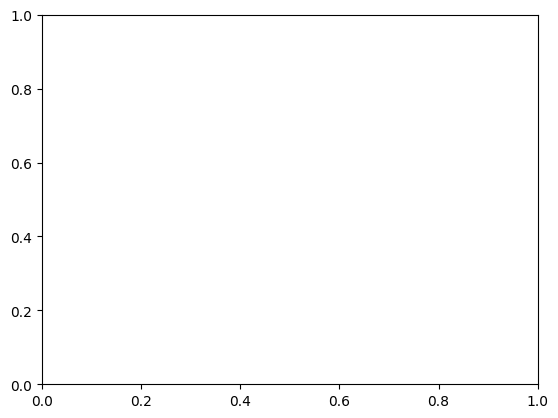

In [123]:
x_lables = y_labels
plot_pdf_comparison_with_df(dataset_original,dataset_decompressed, x_lables)

#### Descriptive Statistics

In [124]:
dataset_original.describe()

,battery_voltage,engine_load,rpm,speed,throttle
count,10365.000000,10365.000000,10365.000000,10365.000000,10365.000000
mean,13.520485,11.067824,1608.331597,45.419875,18.863676
std,0.787704,8.377027,442.919476,25.966755,7.547204
min,10.640000,0.000000,0.000000,0.000000,11.000000
25%,12.820000,4.000000,1379.000000,25.000000,14.000000
50%,13.350000,9.000000,1617.000000,48.000000,18.000000
75%,14.080000,15.000000,1875.000000,66.000000,21.000000
max,15.390000,49.000000,3401.000000,102.000000,88.000000


In [125]:
dataset_decompressed.describe()

,battery_voltage,engine_load,rpm,speed,throttle
count,10365.000000,10365.000000,10365.000000,10365.000000,10365.000000
mean,13.551749,10.933816,1610.833767,45.298119,18.774433
std,0.722083,7.689807,415.799290,25.325780,6.991390
min,10.740000,1.000000,831.000000,0.000000,11.000000
25%,12.924286,4.571429,1371.363636,24.857143,14.000000
50%,13.395000,9.363636,1624.125000,48.000000,17.428571
75%,14.111111,14.857143,1853.428571,65.800000,21.000000
max,15.290000,49.000000,3360.000000,102.000000,88.000000


#### RMSE

In [126]:
calculate_rmse(dataset_original, dataset_decompressed)

{'battery_voltage': 0.5633424638005453,
 'engine_load': 5.330259873459563,
 'rpm': 295.73080100296227,
 'speed': 11.887364820381885,
 'throttle': 5.523436196892882}

#### NCC

In [127]:
# Calculate the normalized cross-correlation
corr_results = calculate_normalized_cross_correlation(dataset_original, dataset_decompressed)
print(corr_results)

{'battery_voltage': 0.7256431212145332, 'engine_load': 0.7832569968158453, 'rpm': 0.7645505528066291, 'speed': 0.8928745923688036, 'throttle': 0.713880942334172, 'Total': 0.7760412411079967}


In [128]:
pd.DataFrame(data=[corr_results])

,battery_voltage,engine_load,rpm,speed,throttle,Total
0,0.725643,0.783257,0.764551,0.892875,0.713881,0.776041


In [129]:
len(corr_results.values()), corr_results.values()

(6,
 dict_values([0.7256431212145332, 0.7832569968158453, 0.7645505528066291, 0.8928745923688036, 0.713880942334172, 0.7760412411079967]))

#### CF<sub>β</sub>

In [130]:
# def CFScore(beta, cr, ncc):
#     return (1+beta**2)*(cr*ncc)/((beta**2)*cr + ncc)
cr = 1 - 1707/dataset_original.shape[0]
for var in corr_results:
    print(f'{var}: {CFScore(1, cr, corr_results[var])}')

battery_voltage: 0.7766246570819229
engine_load: 0.808447023367216
rpm: 0.7983660061603902
speed: 0.8631341888410171
throttle: 0.7698370158758846
Total: 0.8045861384752915


## Algorithm 2: MSTAC (Sequential Execution)

### Hyperparameter Optimization

In [43]:
%%time
window_size = np.arange(2, 30, 1)
m = np.round(np.arange(0.1, 2.1, 0.1), 2)
mstac_grid_search_results_battery_voltage = MPTAC_TAC_Optimizer(pd.DataFrame(dataset_original['battery_voltage']), window_size, m)
mstac_grid_search_results_battery_voltage

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
CPU times: user 19min 21s, sys: 19.6 s, total: 19min 41s
Wall time: 19min 43s


,windowLimit,m,battery_voltage,total,compresionRatio,compressionFactor,CFScore
2,4.0,0.1,0.742419,0.742419,0.838109,6.176996,0.787368
30,4.0,0.2,0.737955,0.737955,0.842065,6.331704,0.786580
58,4.0,0.3,0.730270,0.730270,0.847660,6.564281,0.784598
3,5.0,0.1,0.719679,0.719679,0.861746,7.233077,0.784331
1,3.0,0.1,0.764405,0.764405,0.804727,5.121047,0.784048
...,...,...,...,...,...,...,...
527,25.0,1.9,-0.130919,-0.130919,0.998939,942.272727,-0.301329
526,24.0,1.9,-0.132624,-0.132624,0.998939,942.272727,-0.305853
501,27.0,1.8,-0.135981,-0.135981,0.998360,609.705882,-0.314846
436,18.0,1.6,-0.149003,-0.149003,0.995466,220.531915,-0.350463


In [44]:
%%time
window_size = np.arange(2, 30, 1)
m = np.round(np.arange(0.1, 2.1, 0.1), 2)
mstac_grid_search_results_engine_load = MPTAC_TAC_Optimizer(pd.DataFrame(dataset_original['engine_load']), window_size, m)
mstac_grid_search_results_engine_load

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
CPU times: user 17min 55s, sys: 5.37 s, total: 18min
Wall time: 18min 9s


,windowLimit,m,engine_load,total,compresionRatio,compressionFactor,CFScore
3,5.0,0.1,0.771694,0.771694,0.871587,7.787378,0.818604
5,7.0,0.1,0.746380,0.746380,0.899180,9.918660,0.815686
4,6.0,0.1,0.754516,0.754516,0.887024,8.851409,0.815422
59,5.0,0.3,0.760351,0.760351,0.878726,8.245823,0.815264
32,6.0,0.2,0.749920,0.749920,0.889436,9.044503,0.813741
...,...,...,...,...,...,...,...
558,28.0,2.0,-0.098746,-0.098746,0.999035,1036.500000,-0.219153
553,23.0,2.0,-0.110436,-0.110436,0.998746,797.307692,-0.248331
502,28.0,1.8,-0.111434,-0.111434,0.998456,647.812500,-0.250867
529,27.0,1.9,-0.116454,-0.116454,0.998842,863.750000,-0.263646


In [45]:
%%time
window_size = np.arange(2, 30, 1)
m = np.round(np.arange(0.1, 2.1, 0.1), 2)
MPTAC_TAC_Optimizer(pd.DataFrame(dataset_original['rpm']), window_size, m)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
CPU times: user 18min 4s, sys: 5.41 s, total: 18min 9s
Wall time: 18min 18s


,windowLimit,m,rpm,total,compresionRatio,compressionFactor,CFScore
3,5.0,0.1,0.763290,0.763290,0.860781,7.182952,0.809110
31,5.0,0.2,0.758397,0.758397,0.864641,7.387741,0.808041
6,8.0,0.1,0.725303,0.725303,0.903329,10.344311,0.804586
2,4.0,0.1,0.770225,0.770225,0.837241,6.144043,0.802336
33,7.0,0.2,0.725169,0.725169,0.895417,9.561808,0.801351
...,...,...,...,...,...,...,...
535,5.0,2.0,-0.093670,-0.093670,0.995369,215.937500,-0.206802
544,14.0,2.0,-0.120791,-0.120791,0.997588,414.600000,-0.274864
536,6.0,2.0,-0.120833,-0.120833,0.995369,215.937500,-0.275058
537,7.0,2.0,-0.131302,-0.131302,0.995948,246.785714,-0.302483


In [46]:
%%time
window_size = np.arange(2, 30, 1)
m = np.round(np.arange(0.1, 2.1, 0.1), 2)
MPTAC_TAC_Optimizer(pd.DataFrame(dataset_original['speed']), window_size, m)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
CPU times: user 18min 9s, sys: 5.37 s, total: 18min 14s
Wall time: 18min 23s


,windowLimit,m,speed,total,compresionRatio,compressionFactor,CFScore
53,27.0,0.2,0.855199,0.855199,0.968355,31.600610,0.908266
20,22.0,0.1,0.860537,0.860537,0.960540,25.342298,0.907793
18,20.0,0.1,0.862423,0.862423,0.957067,23.292135,0.907283
45,19.0,0.2,0.862226,0.862226,0.956585,23.033333,0.906958
21,23.0,0.1,0.857542,0.857542,0.962373,26.576923,0.906939
...,...,...,...,...,...,...,...
551,21.0,2.0,-0.021136,-0.021136,0.998553,691.000000,-0.043186
557,27.0,2.0,-0.035118,-0.035118,0.998939,942.272727,-0.072796
555,25.0,2.0,-0.078385,-0.078385,0.998842,863.750000,-0.170120
556,26.0,2.0,-0.091768,-0.091768,0.998842,863.750000,-0.202105


In [47]:
%%time
window_size = np.arange(2, 30, 1)
m = np.round(np.arange(0.1, 2.1, 0.1), 2)
MPTAC_TAC_Optimizer(pd.DataFrame(dataset_original['throttle']), window_size, m)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
CPU times: user 18min 1s, sys: 5.41 s, total: 18min 6s
Wall time: 18min 15s


,windowLimit,m,throttle,total,compresionRatio,compressionFactor,CFScore
1,3.0,0.1,0.763766,0.763766,0.824699,5.704458,0.793064
5,7.0,0.1,0.708021,0.708021,0.899469,9.947217,0.792345
85,3.0,0.4,0.746461,0.746461,0.838881,6.206587,0.789977
57,3.0,0.3,0.743785,0.743785,0.834539,6.043732,0.786553
29,3.0,0.2,0.748839,0.748839,0.827689,5.803471,0.786292
...,...,...,...,...,...,...,...
467,21.0,1.7,-0.046606,-0.046606,0.997877,471.136364,-0.097779
539,9.0,2.0,-0.048580,-0.048580,0.997685,431.875000,-0.102134
500,26.0,1.8,-0.049016,-0.049016,0.998456,647.812500,-0.103093
440,22.0,1.6,-0.049509,-0.049509,0.997974,493.571429,-0.104188


### Compression

In [131]:
mList = [0.1,0.1,0.1,0.2,0.1]
windowLimitList = [4,5,5,27,3]

In [132]:
dataset_compressed_sequential_df, mask_df = MSTAC(dataset_original, windowLimitList, mList)
dataset_compressed_sequential_df

,battery_voltage,engine_load,rpm,speed,throttle
0,14.12,9.0,1386.0,49.0,18.0
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,25.0
...,...,...,...,...,...
10360,NaN,NaN,NaN,NaN,NaN
10361,13.39,10.0,NaN,NaN,NaN
10362,NaN,NaN,NaN,NaN,NaN
10363,NaN,NaN,NaN,NaN,14.0


In [81]:
print(f"Average processing time per sample: {(9.28/dataset_original.shape[0])*1000} ms")

Average processing time per sample: 0.8953207911239748 ms


### Decompression

In [133]:
dataset_decompressed_sequential_df = dataset_compressed_sequential_df.interpolate(method='linear')
dataset_decompressed_sequential_df

,battery_voltage,engine_load,rpm,speed,throttle
0,14.120000,9.000000,1386.00,49.000000,18.00
1,13.836000,10.333333,1418.00,49.333333,19.75
2,13.552000,11.666667,1450.00,49.666667,21.50
3,13.268000,13.000000,1482.00,50.000000,23.25
4,12.984000,14.333333,1514.00,50.333333,25.00
...,...,...,...,...,...
10360,13.386667,9.454545,659.00,2.000000,17.60
10361,13.390000,10.000000,494.25,2.000000,16.40
10362,13.390000,10.000000,329.50,2.000000,15.20
10363,13.390000,10.000000,164.75,2.000000,14.00


### Results

#### Plot

In [142]:
y_labels = ['Battery Voltage', 'Engine Load', 'RPM', 'Speed', 'Throttle']
x_range = (4100,4600)
plot_dataframes_with_mask_df_teste(dataset_original, dataset_decompressed_sequential_df, mask_df, y_labels, x_range, margin_factor=0.20)

#### FDPs

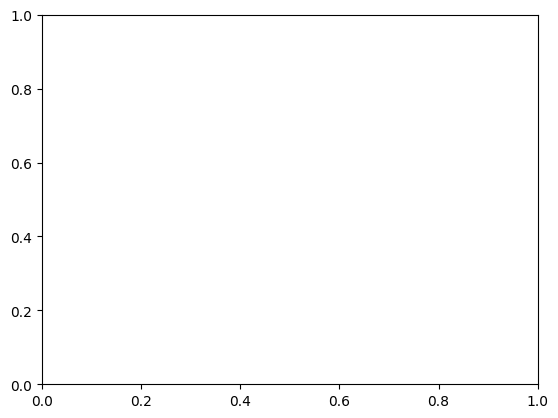

In [135]:
# plot_pdf_comparison(dataset_original, dataset_decompressed_sequential_df)
x_lables = y_labels
plot_pdf_comparison_with_df(dataset_original,dataset_decompressed_sequential_df, x_lables)

#### Descriptive Statistics

#### RMSE

In [136]:
calculate_rmse(dataset_original, dataset_decompressed_sequential_df)

{'battery_voltage': 0.541857504503483,
 'engine_load': 5.428735147835063,
 'rpm': 294.6842178830954,
 'speed': 13.60590036016912,
 'throttle': 5.003061835671504}

#### NCC

In [137]:
# Calculate the normalized cross-correlation
corr_results = calculate_normalized_cross_correlation(dataset_original, dataset_decompressed_sequential_df)
print(corr_results)

{'battery_voltage': 0.7424194651011318, 'engine_load': 0.7716939941018676, 'rpm': 0.7632902308039817, 'speed': 0.8551986242713931, 'throttle': 0.763765924799601, 'Total': 0.779273647815595}


In [138]:
pd.DataFrame(data=[corr_results])

,battery_voltage,engine_load,rpm,speed,throttle,Total
0,0.742419,0.771694,0.76329,0.855199,0.763766,0.779274


In [139]:
len(corr_results.values()), corr_results.values()

(6,
 dict_values([0.7424194651011318, 0.7716939941018676, 0.7632902308039817, 0.8551986242713931, 0.763765924799601, 0.779273647815595]))

#### CF<sub>β</sub>

In [140]:
number_of_saved_samples_dict = dataset_compressed_sequential_df.notnull().sum().to_dict()
number_of_saved_samples_dict

{'battery_voltage': 1678,
 'engine_load': 1331,
 'rpm': 1443,
 'speed': 328,
 'throttle': 1817}

In [141]:
# def CFScore(beta, cr, ncc):
#     return (1+beta**2)*(cr*ncc)/((beta**2)*cr + ncc)

for var in corr_results:
    if var == 'Total':
        break
    cf = dataset_original.shape[0] / number_of_saved_samples_dict[var]
    cr = 1 - 1/cf
    print(f'{var}: CF_b = {CFScore(1, cr, corr_results[var])} \t CR = {cr} \t CF = {cf}')

battery_voltage: CF_b = 0.7873675880559535 	 CR = 0.8381090207428847 	 CF = 6.176996424314661
engine_load: CF_b = 0.8186043430172215 	 CR = 0.8715870718765075 	 CF = 7.787377911344853
rpm: CF_b = 0.8091097071377541 	 CR = 0.860781476121563 	 CF = 7.1829521829521825
speed: CF_b = 0.9082660024130128 	 CR = 0.9683550410033768 	 CF = 31.600609756097562
throttle: CF_b = 0.7930635453743239 	 CR = 0.8246985045827303 	 CF = 5.7044578976334614


## Draft